In [14]:
!pip install pytorch-lightning transformers torch torchvision matplotlib opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.4/35.4 MB 8.9 MB/s eta 0:00:0000:0100:01


In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

import pytorch_lightning as pl


random_seed = 42
torch.manual_seed(random_seed)

PATH_DATASETS = os.environ.get("PATH_DATASETS", "data/MNIST/raw")
BATCH_SIZE= 256 if torch.cuda.is_available() else 64
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2)

/Users/cuburtbalanon/anaconda3/envs/gan/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# import gzip
# import shutil

# import os
# import gzip
# import shutil

# def extract_gz_files_in_directory(directory_path, output_directory):
#     # Ensure the output directory exists
#     os.makedirs(output_directory, exist_ok=True)

#     # List all files in the directory
#     for file_name in os.listdir(directory_path):
#         if file_name.endswith('.gz'):
#             file_path = os.path.join(directory_path, file_name)
#             output_path = os.path.join(output_directory, file_name[:-3])  # Remove the .gz extension

#             # Extract the .gz file
#             with gzip.open(file_path, 'rb') as f_in:
#                 with open(output_path, 'wb') as f_out:
#                     shutil.copyfileobj(f_in, f_out)
#             print(f'Extracted {file_name} to {output_path}')

# # Example usage
# extract_gz_files_in_directory(PATH_DATASETS, PATH_DATASETS)

In [3]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(
        self,
        data_dir: str = "data/new/",
        batch_size: int = BATCH_SIZE,
        num_workers: int = NUM_WORKERS,
    ):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

        self.dims = (1, 28, 28)
        self.num_classes = 10

    def prepare_data(self):
        # download
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, download=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, download=True, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(
            self.mnist_train,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
        )

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [4]:
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader


mnist = MNISTDataModule()
mnist.setup()


class Annotated_MNIST(Dataset):

    def __init__(self, train=False):

        if train:
            self.batches = mnist.train_dataloader()
        else:
            self.batches = mnist.test_dataloader()

        images, labels = next(iter(self.batches))
        self.labels = labels.numpy()
        self.images = images.numpy().reshape(-1, 28, 28)

        self.nwords = 6
        self.vocab_size = 19
        self.mnist_settings = {0: {'bound': 10, 'skew_range': 60, 'mean': 8, 'line': 14, 'thickness_range': 2}, \
                               1: {'bound': 6, 'skew_range': 25, 'mean': 4, 'line': 20, 'thickness_range': 1},  \
                               2: {'bound': 10, 'skew_range': 60, 'mean': 5, 'line': 11, 'thickness_range': 2}, \
                               3: {'bound': 14, 'skew_range': 20, 'mean': 5, 'line': 18, 'thickness_range': 2}, \
                               4: {'bound': 20, 'skew_range': 50, 'mean': 8, 'line': 10, 'thickness_range': 2}, \
                               5: {'bound': 10, 'skew_range': 30, 'mean': 8, 'line': 20, 'thickness_range': 6}, \
                               6: {'bound': 10, 'skew_range': 25, 'mean': 5, 'line': 7, 'thickness_range': 2},  \
                               7: {'bound': 6, 'skew_range': 20, 'mean': 4, 'line': 22, 'thickness_range': 0},  \
                               8: {'bound': 12, 'skew_range': 25, 'mean': 9, 'line': 10, 'thickness_range': 2}, \
                               9: {'bound': 10, 'skew_range': 30, 'mean': 4, 'line': 22, 'thickness_range': 0}}

        self.word2idx = {'thin': 0, 'normal': 1, 'thick': 2, \
                         'number': 3, \
                         'zero': 4, 'one': 5, 'two': 6, 'three': 7, 'four': 8, 'five': 9, 'six': 10, 'seven': 11, 'eight': 12, 'nine': 13, \
                         'with': 14, \
                         'left': 15, 'average': 16, 'right': 17, \
                         'skew': 18}

        self.idx2word = {idx: word for (word, idx) in self.word2idx.items()}

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        description = self.get_description(img, label)
        return img, description

    def get_nums(self, num):
        idx = np.where(self.labels == num)[0]
        nums = self.images[idx]
        return idx, nums


    def thickness_stats(self, num, line, thickness_range):
        idx, nums = self.get_nums(num)

        m = int(np.mean(np.sum(nums[:, line, :] != 0, axis=1)))
        t_lb = int(m - thickness_range / 2)
        t_ub = int(m + thickness_range / 2)

        l_idx = np.where(np.sum(nums[:, line, :] != 0, axis=1) < t_lb)
        n_idx = np.where(np.logical_and(np.sum(nums[:, line, :] != 0, axis=1) >= t_lb, np.sum(nums[:, line, :] != 0, axis=1) <= t_ub))
        h_idx = np.where(np.sum(nums[:, line, :] != 0, axis=1) > t_ub)

        l_idx = idx[l_idx]
        n_idx = idx[n_idx]
        h_idx = idx[h_idx]

        print('Low: {}\nNormal: {}\nHigh: {}\n'.format(len(l_idx), len(n_idx), len(h_idx)))

        return l_idx, n_idx, h_idx


    def get_thickness(self, img, mean, line, thickness_range):
        t_lb = int(mean - thickness_range / 2)
        t_ub = int(mean + thickness_range / 2)

        if np.sum(img[line, :] != 0) < t_lb:
            return 'thin'
        elif np.logical_and(np.sum(img[line, :] != 0) >= t_lb, np.sum(img[line, :] != 0) <= t_ub):
            return 'normal'
        else:
            return 'thick'


    def __rotate_and_scale(self, img, angle, scale):
        M = cv2.getRotationMatrix2D((14, 14), angle, scale)
        return cv2.warpAffine(img, M, (28, 28))


    def skew_stats(self, num, bound, skew_range):
        lb = int(14 - bound / 2)
        ub = int(14 + bound / 2)
        s_lb = -int(skew_range / 2)
        s_ub = int(skew_range / 2)

        idx, nums = self.get_nums(num)

        skews = []
        for num in nums:

            li = []
            max_overlap = 0
            max_angle = 0
            for angle in range(-90, 90, 5):
                temp1 = self.__rotate_and_scale(num, angle, 1)
                temp2 = temp1[:, lb:ub]

                if max_overlap <= np.sum(temp2 != 0):
                    max_overlap = np.sum(temp2 != 0)
                    max_angle = angle

            skews.append(max_angle)

        skews = np.array(skews)
        l_idx = np.where(skews < s_lb)
        n_idx = np.where(np.logical_and(skews >= s_lb, skews <= s_ub))
        h_idx = np.where(skews > s_ub)

        l_idx = idx[l_idx]
        n_idx = idx[n_idx]
        h_idx = idx[h_idx]

        print('Low: {}\nNormal: {}\nHigh: {}\n'.format(len(l_idx), len(n_idx), len(h_idx)))

        return l_idx, n_idx, h_idx


    def get_skew(self, img, bound, skew_range):
        lb = int(14 - bound / 2)
        ub = int(14 + bound / 2)
        s_lb = -int(skew_range / 2)
        s_ub = int(skew_range / 2)

        max_overlap = 0
        max_angle = 0
        for angle in range(-90, 90, 5):
            temp1 = self.__rotate_and_scale(img, angle, 1)
            temp2 = temp1[:, lb:ub]

            if max_overlap <= np.sum(temp2 != 0):
                max_overlap = np.sum(temp2 != 0)
                max_angle = angle

        if max_angle < s_lb:
            return 'left skew'
        elif np.logical_and(max_angle >= s_lb, max_angle <= s_ub):
            return 'average skew'
        else:
            return 'right skew'


    def get_description(self, img, num):

        settings = self.mnist_settings[num]
        bound = settings['bound']
        skew_range = settings['skew_range']
        mean = settings['mean']
        line = settings['line']
        thickness_range = settings['thickness_range']

        skew = self.get_skew(img, bound, skew_range)
        thickness = self.get_thickness(img, mean, line, thickness_range)

        if num == 0:
            number = 'zero'
        elif num == 1:
            number = 'one'
        elif num == 2:
            number = 'two'
        elif num == 3:
            number = 'three'
        elif num == 4:
            number = 'four'
        elif num == 5:
            number = 'five'
        elif num == 6:
            number = 'six'
        elif num == 7:
            number = 'seven'
        elif num == 8:
            number = 'eight'
        else:
            number = 'nine'

        res = thickness + ' number ' + number + ' with ' + skew

        return res


    def next_batch(self, batch_size, resize=False, convert_to_idx=True):
        images, labels = next(iter(self.batches))

        images = images.numpy().reshape(-1, 28, 28)
        labels = labels.numpy()

        descriptions = []

        for i in range(batch_size):
            img = images[i]
            num = labels[i]
            description = self.get_description(img, num).split()

            if convert_to_idx:
                temp = list(map(self.word2idx.get, description))
                descriptions.append(temp)
            else:
                descriptions.append(description)

        if resize:

            batch_xs = np.reshape(images, [-1, 784])
            images_small = []

            for i in range(batch_size):
                images_small.append(cv2.resize(images[i], (14, 14), interpolation=0))

            images_small = np.array(images_small)
            batch_xs_small = np.reshape(images_small, [-1, 196])
            batch_ys = labels

            return descriptions, batch_xs, batch_xs_small, batch_ys

        else:
            batch_xs = np.reshape(images, [-1, 784])
            batch_ys = labels

            return descriptions, batch_xs, batch_ys


    def generate_sentences(self, num, divide=True, convert_to_idx=True):
        sentences = []

        thickness = ['thin', 'normal', 'thick']
        nums = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
        skew = ['left skew', 'average skew', 'right skew']

        for i in range(num):
            sentence = ''

            sentence += random.choice(thickness)
            sentence += ' number '
            sentence += random.choice(nums)
            sentence += ' with '
            sentence += random.choice(skew)

            if divide:
                sentences.append(sentence.split())
            else:
                sentences.append(sentence)

        if convert_to_idx:

            for i in range(num):
                sentences[i] = list(map(self.word2idx.get, sentences[i]))

            return sentences

        else:

            return sentences


    def convert_to_word(self, sentences, concat=True):
        res = []

        for sentence in sentences:
            res.append(list(map(self.idx2word.get, sentence)))

        if concat:

            for i in range(len(res)):

                sent = ''
                for word in res[i]:
                    sent += word + ' '

                res[i] = str.rstrip(sent)

        return res


    def convert_to_idx(self, sentences):
        res = []

        for sentence in sentences:
            res.append(list(map(self.word2idx.get, sentence.split())))

        return res

In [152]:
for i in range(100):
    descriptions, batch_xs, batch_ys = test.next_batch(128, resize=False, convert_to_idx=False)

imgs = np.reshape(batch_xs, (-1, 28, 28))

plt.figure(figsize=(12, 12))
for i in range(25):
    plt.subplot(5, 5, (i + 1))
    plt.imshow(imgs[i], interpolation='NONE', vmin=0, vmax=1, cmap=plt.get_cmap('gray'))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

IndexError: index 64 is out of bounds for axis 0 with size 64

In [73]:
from typing import Any, Dict, List, Optional
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizerFast

DEFAULT_MODEL_NAME = "openai/clip-vit-base-patch32"
DEFAULT_DEVICE = f'cuda:{torch.cuda.current_device()}' if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")


class CLIPDiscriminator(nn.Module):

    def __init__(self):
        super(CLIPDiscriminator, self).__init__()
        self.model = CLIPModel.from_pretrained(DEFAULT_MODEL_NAME).to(DEFAULT_DEVICE)
        self.model.eval()
        for param in self.model.parameters():
            param.requires_grad = False
        self.tokenizer = CLIPTokenizerFast.from_pretrained(DEFAULT_MODEL_NAME)
        self.processor = CLIPProcessor.from_pretrained(DEFAULT_MODEL_NAME)
        

    def encode_image(self, images):
        images = (images + 1) / 2  # Normalize images to the range [0, 1]
        images = [transforms.ToPILImage()(img.cpu()) for img in images]
        inputs = self.processor(images=images, return_tensors="pt")
        image_features = self.model.get_image_features(**inputs.to(DEFAULT_DEVICE))
        image_features.requires_grad=True
        return image_features #([batch_size, latent_dim])

    def encode_text(self, texts):
        inputs = self.processor(text=texts, return_tensors="pt", truncation=True)
        text_features = self.model.get_text_features(**inputs.to(DEFAULT_DEVICE))
        text_features.requires_grad=True
        return text_features #([batch_size, text_dim])

    def forward(self, real_images, images, texts):
        cos = torch.nn.CosineSimilarity(dim=0)
        m = nn.Sigmoid()
        real_image_features = self.encode_image(real_images)
        fake_image_features = self.encode_image(images)
        cos_probs = m(F.cosine_similarity(real_image_features, fake_image_features, dim=-1))
        images = (images + 1) / 2  # Normalize images to the range [0, 1]
        images = [transforms.ToPILImage()(img.cpu()) for img in images]
        inputs = self.processor(text=texts, images=images, return_tensors="pt", padding=True)
        outputs = self.model(**inputs.to(DEFAULT_DEVICE))
        logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
        img_probs = logits_per_image.softmax(dim=1)
        assert img_probs.numel() != 0, "Input tensors must not be empty."
        assert img_probs.shape == (64, 64), "Input tensors must have shape [64, 64]."
        return (torch.mean(img_probs, dim=0, keepdim=False).to(DEFAULT_DEVICE) + cos_probs.to(DEFAULT_DEVICE)) / 2
        # return img_probs.squeeze(), lbl_probs.squeeze()


In [74]:
# Define the Generator
class Generator(nn.Module):
    def __init__(self, noise_dim=100, text_dim=512, image_channels=1, feature_dim=64):
        super(Generator, self).__init__()
        self.feature_dim = feature_dim
        self.fc = nn.Linear(noise_dim + text_dim, feature_dim * 8)
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(feature_dim * 8, feature_dim * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_dim * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_dim * 4, feature_dim * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_dim * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_dim * 2, feature_dim, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_dim, image_channels, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.Tanh()
        )

    def forward(self, noise, text_embedding):
        z = torch.cat((noise.to(DEFAULT_DEVICE), text_embedding.to(DEFAULT_DEVICE)), dim=1)
        z = self.fc(z)
        z = z.view(-1, self.feature_dim * 8, 1, 1)
        return self.gen(z)

# Define the GAN Lightning Module
class GAN(pl.LightningModule):
    def __init__(self, noise_dim=100, text_dim=512, image_channels=1, feature_dim=128, lr=0.0001, b1=0.5, b2=0.999):
        super(GAN, self).__init__()
        self.save_hyperparameters()
        self.automatic_optimization=True
        self.noise_dim = noise_dim

        # Generator
        self.generator = Generator(noise_dim=noise_dim, text_dim=text_dim, image_channels=image_channels, feature_dim=feature_dim)
        # Load CLIP model
        self.discriminator = CLIPDiscriminator()
        

        self.validation_z = torch.randn(6, self.hparams.noise_dim).to(DEFAULT_DEVICE)
        self.validation_text = self.discriminator.encode_text(["a number one with thick lines",
                                                 "a number two with thick lines",
                                                 "a number three with thick lines",
                                                 "a number four with thick lines",
                                                 "a number five with thick lines",
                                                 "a number six with thick lines"]).to(DEFAULT_DEVICE)

    def forward(self, noise, text_embedding):
        return self.generator(noise, text_embedding)

    def clip_discriminator_loss(self, real_images, fake_images, text_embeddings, criterion):
        real_image_features = self.discriminator.encode_image(real_images)
        real_image_features.requires_grad=True
        fake_image_features = self.discriminator.encode_image(fake_images)
        fake_image_features.requires_grad=True
        text_features = text_embeddings
        
        target = torch.ones(real_image_features.size(0), requires_grad=True).to(DEFAULT_DEVICE) # argmax: y=1, argmin: y=-1

        # log2 (1 - cosine)
        # img_loss = torch.log2(criterion(fake_image_features, real_image_features, target) + 1)
        # txt_loss = torch.log2(criterion(fake_image_features, text_features, target) + 1)
        m = nn.Sigmoid()
        out = m((F.cosine_similarity(real_image_features, fake_image_features, dim=-1) + (F.cosine_similarity(real_image_features, text_features, dim=-1) + F.cosine_similarity(fake_image_features, text_features, dim=-1)))/2)
        # loss = (img_loss + txt_loss) / 2
        return out
        
    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat ,y)

    def generator_loss(self, fake_images, text_embeddings):
        fake_image_features = self.encode_image(fake_images).float()
        text_features = text_embeddings.float()
        print(text_features.shape)
        print(fake_image_features.shape)
        # return torch.mean((fake_image_features - text_features) ** 2)
        cosine_sim = torch.nn.functional.cosine_similarity(fake_image_features, text_features, dim=-1)
        return 1 - torch.mean(cosine_sim)

    # def generator_loss(self, fake_images, text_embeddings):
    #   fake_image_features = self.encode_image(fake_images).float()
    #   text_features = text_embeddings.float()

    #   # Compute the mean squared error (MSE) between fake image features and text features
    #   mse_loss = nn.MSELoss()
    #   loss = mse_loss(fake_image_features, text_features)

    #   return loss

    def training_step(self, batch, batch_idx):
        real_images, text_descriptions = batch
        
        # loss functions
        criterion = nn.CosineEmbeddingLoss()

        optimizer = self.optimizers()
            
        z = torch.randn(real_images.shape[0], self.noise_dim, requires_grad=True)
        z = z.type_as(real_images)

        h = self.discriminator.encode_text(text_descriptions)
        
        # Train generator
        
        x_hat = self(z, h) # image generated by generator

        y_hat = self.discriminator(real_images, x_hat, text_descriptions)
        # y_hat = self.clip_discriminator_loss(real_images, x_hat, h, criterion)
        y = torch.ones(real_images.shape[0], device=DEFAULT_DEVICE)
        print("y_hat: ", y_hat)
        print("y: ", y)
        g_loss = self.adversarial_loss(y_hat, y)
        
        self.log('g_loss', g_loss, prog_bar=True)
        g_loss.backward()
        optimizer.step()
        optimizer.zero_grad()


    def configure_optimizers(self):
        for param in self.generator.parameters():
            param.requires_grad = True
        optimizer = optim.Adam(self.generator.parameters(), lr=self.hparams.lr, betas=(self.hparams.b1, self.hparams.b2))
        return [optimizer], []


    def plot_imgs(self):
        noise = self.validation_z
        text = self.validation_text
        sample_imgs = self(noise, text).cpu()

        print('epoch ', self.current_epoch)
        fig = plt.figure()
        for i in range(sample_imgs.size(0)):
          plt.subplot(2, 3, i+1)
          plt.tight_layout()
          plt.imshow(sample_imgs.detach()[i, 0, :, :], cmap='gray_r', interpolation='none')
          plt.title("Generated Data")
          plt.xticks([])
          plt.yticks([])
          plt.axis('off')
        plt.show()

    def on_train_epoch_end(self):
        self.plot_imgs()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] y_hat:  tensor([0.3640, 0.3610, 0.3659, 0.3587, 0.3651, 0.3705, 0.3703, 0.3651, 0.3605,
        0.3806, 0.3616, 0.3581, 0.3586, 0.3597, 0.3762, 0.3600, 0.3633, 0.3637,
        0.3565, 0.3638, 0.3683, 0.3643, 0.3629, 0.3609, 0.3582, 0.3713, 0.3597,
        0.3636, 0.3628, 0.3583, 0.3701, 0.3675, 0.3600, 0.3623, 0.3597, 0.3712,
        0.3646, 0.3646, 0.3642, 0.3629, 0.3584, 0.3621, 0.3805, 0.3602, 0.3612,
        0.3660, 0.3622, 0.3592, 0.3611, 0.3613, 0.3794, 0.3647, 0.3605, 0.3634,
        0.3701, 0.3621, 0.3698, 0.3627, 0.3614, 0.3652, 0.3587, 0.3638, 0.3653,
        0.3681], device='mps:0', grad_fn=<DivBackward0>)
y:  tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='mps:0')
Epoch 0: 100%|█████

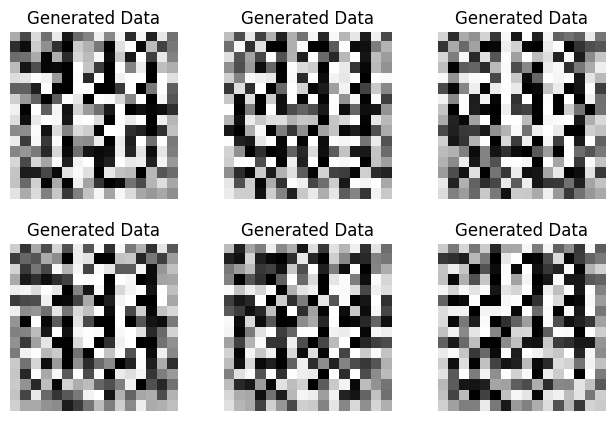

Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=135, g_loss=1.010]        y_hat:  tensor([0.3627, 0.3622, 0.3623, 0.3607, 0.3631, 0.3594, 0.3640, 0.3610, 0.3664,
        0.3683, 0.3759, 0.3615, 0.3605, 0.3647, 0.3661, 0.3711, 0.3585, 0.3581,
        0.3581, 0.3628, 0.3802, 0.3619, 0.3653, 0.3610, 0.3625, 0.3802, 0.3642,
        0.3674, 0.3688, 0.3597, 0.3615, 0.3604, 0.3651, 0.3576, 0.3644, 0.3564,
        0.3633, 0.3589, 0.3629, 0.3635, 0.3654, 0.3591, 0.3605, 0.3628, 0.3700,
        0.3606, 0.3604, 0.3705, 0.3612, 0.3625, 0.3695, 0.3691, 0.3631, 0.3641,
        0.3653, 0.3694, 0.3710, 0.3588, 0.3654, 0.3622, 0.3645, 0.3621, 0.3602,
        0.3794], device='mps:0', grad_fn=<DivBackward0>)
y:  tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dev

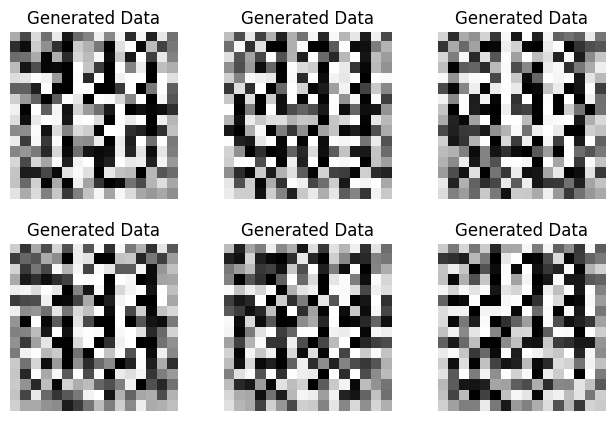

Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=135, g_loss=1.010]        y_hat:  tensor([0.3555, 0.3666, 0.3584, 0.3604, 0.3634, 0.3613, 0.3603, 0.3656, 0.3650,
        0.3580, 0.3582, 0.3602, 0.3790, 0.3687, 0.3652, 0.3638, 0.3636, 0.3580,
        0.3635, 0.3715, 0.3662, 0.3797, 0.3612, 0.3706, 0.3633, 0.3635, 0.3647,
        0.3609, 0.3609, 0.3614, 0.3756, 0.3602, 0.3618, 0.3629, 0.3625, 0.3621,
        0.3710, 0.3707, 0.3613, 0.3725, 0.3621, 0.3683, 0.3637, 0.3802, 0.3628,
        0.3615, 0.3641, 0.3591, 0.3640, 0.3714, 0.3705, 0.3589, 0.3653, 0.3614,
        0.3648, 0.3650, 0.3586, 0.3689, 0.3591, 0.3657, 0.3608, 0.3613, 0.3610,
        0.3572], device='mps:0', grad_fn=<DivBackward0>)
y:  tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dev

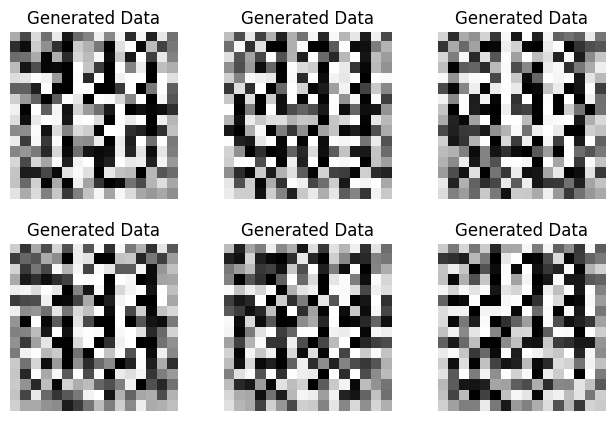

Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, v_num=135, g_loss=1.010]        y_hat:  tensor([0.3590, 0.3581, 0.3568, 0.3605, 0.3808, 0.3629, 0.3706, 0.3596, 0.3668,
        0.3633, 0.3624, 0.3607, 0.3653, 0.3619, 0.3711, 0.3585, 0.3608, 0.3762,
        0.3621, 0.3635, 0.3810, 0.3639, 0.3658, 0.3656, 0.3626, 0.3679, 0.3579,
        0.3597, 0.3715, 0.3652, 0.3640, 0.3601, 0.3545, 0.3627, 0.3634, 0.3582,
        0.3623, 0.3671, 0.3596, 0.3626, 0.3614, 0.3719, 0.3604, 0.3606, 0.3612,
        0.3652, 0.3610, 0.3621, 0.3665, 0.3645, 0.3608, 0.3802, 0.3589, 0.3707,
        0.3718, 0.3589, 0.3623, 0.3607, 0.3684, 0.3638, 0.3647, 0.3644, 0.3705,
        0.3620], device='mps:0', grad_fn=<DivBackward0>)
y:  tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dev

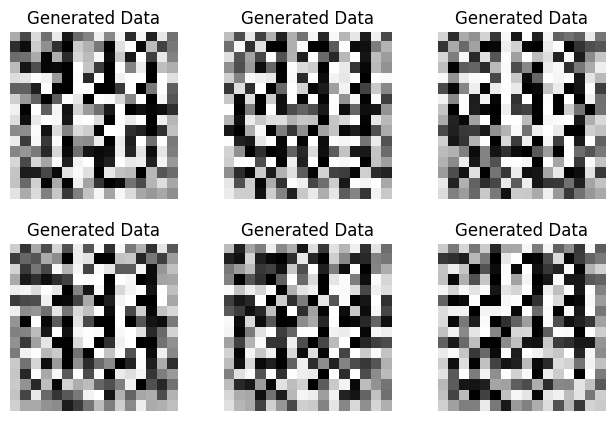

Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, v_num=135, g_loss=1.010]        y_hat:  tensor([0.3629, 0.3594, 0.3580, 0.3596, 0.3631, 0.3618, 0.3675, 0.3634, 0.3631,
        0.3803, 0.3612, 0.3631, 0.3705, 0.3647, 0.3634, 0.3619, 0.3625, 0.3716,
        0.3662, 0.3623, 0.3609, 0.3627, 0.3789, 0.3631, 0.3702, 0.3633, 0.3592,
        0.3715, 0.3607, 0.3579, 0.3596, 0.3589, 0.3605, 0.3632, 0.3635, 0.3603,
        0.3651, 0.3649, 0.3692, 0.3608, 0.3628, 0.3645, 0.3588, 0.3678, 0.3598,
        0.3644, 0.3629, 0.3628, 0.3608, 0.3661, 0.3580, 0.3641, 0.3595, 0.3590,
        0.3702, 0.3587, 0.3665, 0.3640, 0.3649, 0.3758, 0.3789, 0.3695, 0.3554,
        0.3713], device='mps:0', grad_fn=<DivBackward0>)
y:  tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dev

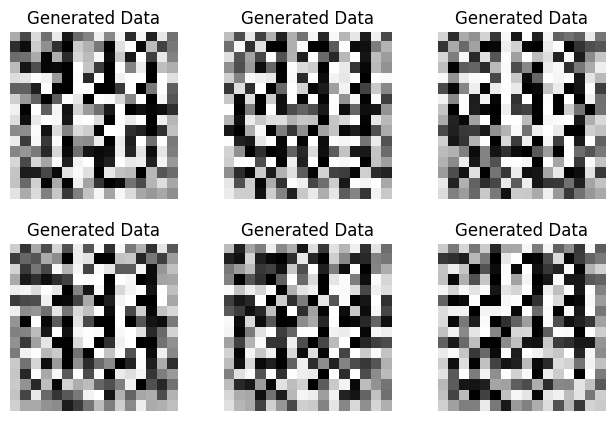

Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s, v_num=135, g_loss=1.010]        y_hat:  tensor([0.3696, 0.3681, 0.3619, 0.3797, 0.3637, 0.3580, 0.3713, 0.3612, 0.3645,
        0.3597, 0.3581, 0.3642, 0.3605, 0.3652, 0.3684, 0.3613, 0.3632, 0.3623,
        0.3659, 0.3706, 0.3587, 0.3605, 0.3629, 0.3589, 0.3605, 0.3648, 0.3631,
        0.3611, 0.3638, 0.3598, 0.3615, 0.3758, 0.3612, 0.3794, 0.3624, 0.3587,
        0.3596, 0.3639, 0.3617, 0.3618, 0.3561, 0.3645, 0.3650, 0.3691, 0.3701,
        0.3712, 0.3606, 0.3648, 0.3639, 0.3703, 0.3617, 0.3629, 0.3591, 0.3713,
        0.3617, 0.3800, 0.3588, 0.3593, 0.3656, 0.3622, 0.3638, 0.3625, 0.3655,
        0.3616], device='mps:0', grad_fn=<DivBackward0>)
y:  tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dev

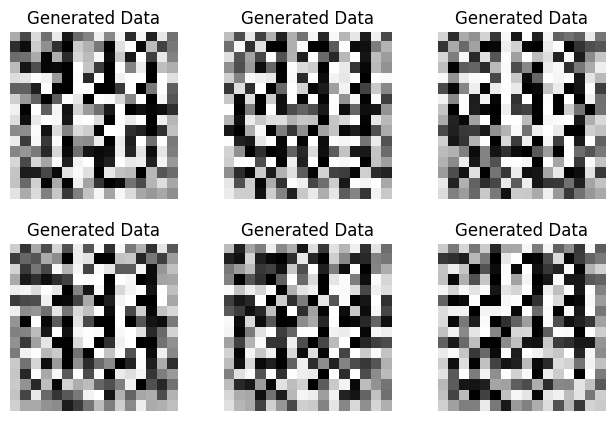

Epoch 6:   0%|          | 0/1 [00:00<?, ?it/s, v_num=135, g_loss=1.010]        y_hat:  tensor([0.3712, 0.3631, 0.3618, 0.3714, 0.3606, 0.3599, 0.3577, 0.3706, 0.3623,
        0.3625, 0.3595, 0.3598, 0.3639, 0.3592, 0.3633, 0.3580, 0.3660, 0.3627,
        0.3647, 0.3600, 0.3629, 0.3646, 0.3636, 0.3608, 0.3647, 0.3594, 0.3621,
        0.3625, 0.3636, 0.3597, 0.3636, 0.3631, 0.3597, 0.3644, 0.3656, 0.3596,
        0.3607, 0.3705, 0.3642, 0.3628, 0.3621, 0.3690, 0.3692, 0.3574, 0.3557,
        0.3614, 0.3699, 0.3705, 0.3640, 0.3670, 0.3615, 0.3803, 0.3641, 0.3602,
        0.3594, 0.3583, 0.3807, 0.3756, 0.3679, 0.3605, 0.3670, 0.3812, 0.3618,
        0.3647], device='mps:0', grad_fn=<DivBackward0>)
y:  tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dev

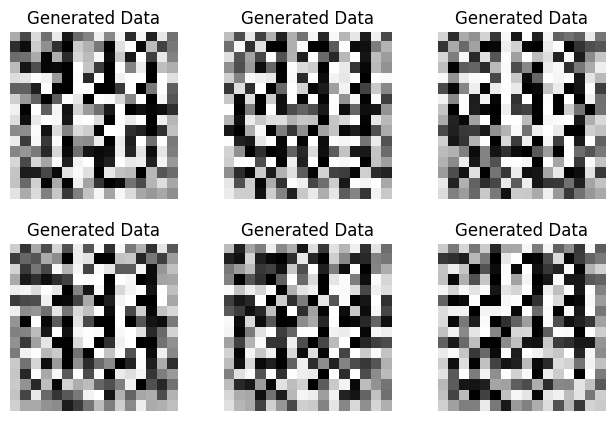

Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s, v_num=135, g_loss=1.010]        y_hat:  tensor([0.3596, 0.3630, 0.3707, 0.3619, 0.3584, 0.3592, 0.3587, 0.3682, 0.3659,
        0.3708, 0.3711, 0.3716, 0.3578, 0.3608, 0.3632, 0.3651, 0.3625, 0.3656,
        0.3794, 0.3647, 0.3631, 0.3618, 0.3614, 0.3626, 0.3652, 0.3624, 0.3630,
        0.3597, 0.3674, 0.3607, 0.3610, 0.3648, 0.3749, 0.3638, 0.3646, 0.3604,
        0.3638, 0.3608, 0.3707, 0.3622, 0.3620, 0.3802, 0.3637, 0.3552, 0.3626,
        0.3613, 0.3702, 0.3628, 0.3619, 0.3593, 0.3595, 0.3593, 0.3629, 0.3707,
        0.3660, 0.3683, 0.3585, 0.3610, 0.3584, 0.3636, 0.3657, 0.3601, 0.3571,
        0.3790], device='mps:0', grad_fn=<DivBackward0>)
y:  tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dev

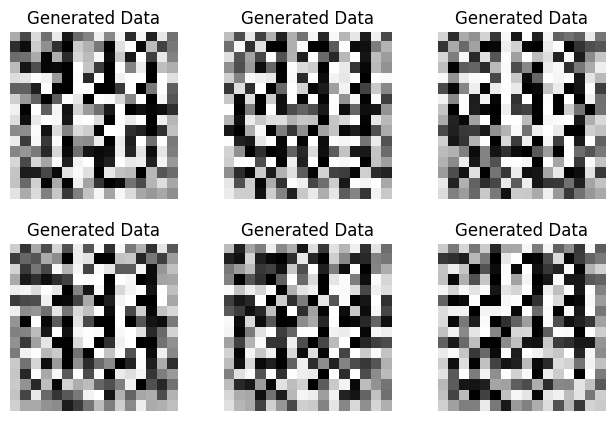

Epoch 8:   0%|          | 0/1 [00:00<?, ?it/s, v_num=135, g_loss=1.010]        y_hat:  tensor([0.3642, 0.3637, 0.3760, 0.3599, 0.3612, 0.3590, 0.3626, 0.3611, 0.3618,
        0.3620, 0.3638, 0.3605, 0.3601, 0.3652, 0.3632, 0.3717, 0.3790, 0.3626,
        0.3695, 0.3640, 0.3638, 0.3610, 0.3632, 0.3662, 0.3632, 0.3589, 0.3614,
        0.3798, 0.3582, 0.3649, 0.3634, 0.3641, 0.3797, 0.3675, 0.3654, 0.3640,
        0.3586, 0.3623, 0.3712, 0.3652, 0.3599, 0.3661, 0.3639, 0.3680, 0.3682,
        0.3709, 0.3603, 0.3620, 0.3589, 0.3710, 0.3577, 0.3602, 0.3586, 0.3607,
        0.3713, 0.3603, 0.3625, 0.3637, 0.3709, 0.3644, 0.3602, 0.3592, 0.3564,
        0.3588], device='mps:0', grad_fn=<DivBackward0>)
y:  tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dev

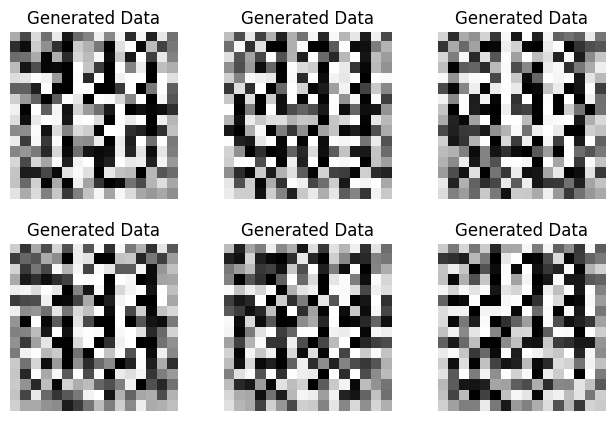

Epoch 9:   0%|          | 0/1 [00:00<?, ?it/s, v_num=135, g_loss=1.010]        y_hat:  tensor([0.3592, 0.3636, 0.3609, 0.3599, 0.3589, 0.3668, 0.3596, 0.3585, 0.3671,
        0.3715, 0.3582, 0.3578, 0.3634, 0.3650, 0.3608, 0.3653, 0.3798, 0.3641,
        0.3676, 0.3615, 0.3622, 0.3572, 0.3643, 0.3620, 0.3707, 0.3609, 0.3627,
        0.3603, 0.3652, 0.3601, 0.3602, 0.3623, 0.3715, 0.3558, 0.3641, 0.3754,
        0.3702, 0.3635, 0.3631, 0.3657, 0.3620, 0.3581, 0.3614, 0.3642, 0.3701,
        0.3623, 0.3599, 0.3793, 0.3643, 0.3641, 0.3613, 0.3624, 0.3618, 0.3704,
        0.3662, 0.3800, 0.3633, 0.3661, 0.3573, 0.3693, 0.3581, 0.3616, 0.3609,
        0.3710], device='mps:0', grad_fn=<DivBackward0>)
y:  tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dev

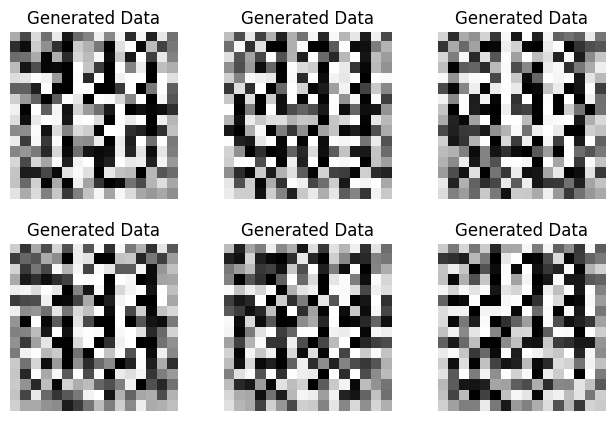

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:02<00:00,  0.45it/s, v_num=135, g_loss=1.010]


In [75]:
# Data Module
class AnnotatedMNISTDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=64):
        super(AnnotatedMNISTDataModule, self).__init__()
        self.batch_size = batch_size

    def prepare_data(self):
        pass  # No data download needed

    def setup(self, stage=None):
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            # transforms.Normalize((0.5,), (0.5,))
            transforms.Normalize((0.1307,), (0.3081,)),
        ])
        self.train_dataset = Annotated_MNIST(train=True)
        self.val_dataset = Annotated_MNIST(train=False)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, collate_fn=self.collate_fn)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, collate_fn=self.collate_fn)

    def collate_fn(self, batch):
        images, text_descriptions = zip(*batch)
        images = torch.stack([self.transform(img) for img in images])
        # print(images, list(text_descriptions))
        return images, list(text_descriptions)

# Train the model
if __name__ == '__main__':
    mnist_dm = AnnotatedMNISTDataModule(batch_size=64)
    model = GAN(feature_dim=64)
    model.to(DEFAULT_DEVICE)

    trainer = pl.Trainer(accelerator='auto', max_epochs=10)
    trainer.fit(model, mnist_dm)


In [138]:
# Manually save the model's state dictionary
torch.save(model.state_dict(), 'models/clip-gan/model_state_dict.pth')

# Optionally save the optimizer's state dictionary if needed
optimizer, _ = model.configure_optimizers()
torch.save(optimizer[0].state_dict(), 'models/clip-gan/g_optimizer_state_dict.pth')
# torch.save(optimizer[1].state_dict(), 'models/d_optimizer_state_dict.pth')

In [139]:
loaded_model = GAN()
loaded_model.load_state_dict(torch.load('models/clip-gan/model_state_dict.pth'))

RuntimeError: Error(s) in loading state_dict for GAN:
	size mismatch for generator.fc.weight: copying a param with shape torch.Size([512, 612]) from checkpoint, the shape in current model is torch.Size([1024, 612]).
	size mismatch for generator.fc.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for generator.gen.0.weight: copying a param with shape torch.Size([512, 256, 4, 4]) from checkpoint, the shape in current model is torch.Size([1024, 512, 4, 4]).
	size mismatch for generator.gen.0.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for generator.gen.1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for generator.gen.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for generator.gen.1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for generator.gen.1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for generator.gen.3.weight: copying a param with shape torch.Size([256, 128, 4, 4]) from checkpoint, the shape in current model is torch.Size([512, 256, 4, 4]).
	size mismatch for generator.gen.3.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for generator.gen.4.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for generator.gen.4.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for generator.gen.4.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for generator.gen.4.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for generator.gen.6.weight: copying a param with shape torch.Size([128, 64, 4, 4]) from checkpoint, the shape in current model is torch.Size([256, 128, 4, 4]).
	size mismatch for generator.gen.6.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for generator.gen.7.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for generator.gen.7.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for generator.gen.7.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for generator.gen.7.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for generator.gen.9.weight: copying a param with shape torch.Size([64, 1, 4, 4]) from checkpoint, the shape in current model is torch.Size([128, 1, 4, 4]).

In [140]:
loaded_model = model
loaded_model.eval()
loaded_model.freeze()
loaded_model = loaded_model.to(DEFAULT_DEVICE)

In [142]:
# Example text descriptions
text_descriptions = ["a number 1 with thick lines"]

# Encode the text descriptions using CLIP
text_features = loaded_model.discriminator.encode_text(text_descriptions)

In [143]:
def generate_images(model, text_features, num_samples=1):
    model.eval()
    z = torch.randn(num_samples, model.noise_dim).to(DEFAULT_DEVICE)  # Generate random noise
    with torch.no_grad():
        generated_images = model(z, text_features)
    return generated_images

In [144]:
num_samples = len(text_descriptions)
generated_images = generate_images(loaded_model, text_features, num_samples)

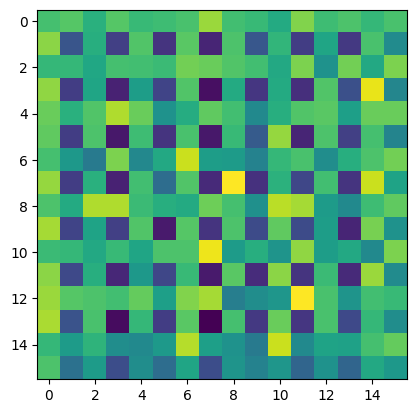

In [145]:
from torchvision.transforms import ToPILImage


def to_pil_images(tensors):
    images = (tensors + 1) / 2  # Normalize from [-1, 1] to [0, 1]
    images = [ToPILImage()(img.view(16, 16).cpu()) for img in images]
    return images

pil_images = to_pil_images(generated_images)

# Display the generated images
for img in pil_images:
    plt.imshow(img)